<a href="https://colab.research.google.com/github/chepkemoi93/Evaluating-tradeoffs-in-credit-scoring/blob/main/Uwezo_fund_evaluating_tradeoffs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, fbeta_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [ ]:
df = pd.read_csv('/content/Uwezofunddatasetmay.csv')
df.head()

,Unnamed: 0,Date of Disbursement,Name of the group/institution,G.F.S.CODE,PAYMENT VOUCHER,CHEQUE NO.,REMARKS,SNo.,Sector,Category,AMOUNT APPROVED,Amount Issued,Amount Due,Amount cummulatively in arrears,Outstanding Loan Balance,Date of Repayment completion,Segment
0,0,2014-12-20 00:00:00.000000000,Name of the group/institution 1,FWGS87327491136730,1,1.0,NaN,1.0,4.0,3.0,150000,2.0,300000.0,300000.0,4.0,2017-06-20,High
1,1,2018-11-23 00:00:00.000000000,Name of the group/institution 2,RJCR13736972987724,1,2.0,NaN,2.0,3.0,3.0,100000,2.0,0.0,-100000.0,NaN,2021-05-23,High
2,2,2014-12-22 00:00:00.000000000,Name of the group/institution 3,FWGS87327491136730,1,3.0,NaN,3.0,4.0,3.0,50000,1.0,150000.0,135334.0,5.0,2017-06-22,High
3,3,2014-12-22 00:00:00.000000000,Name of the group/institution 4,EYPW86233725617229,1,4.0,NaN,4.0,4.0,2.0,90000,2.0,270000.0,270000.0,4.0,2017-06-22,High
4,4,2014-12-22 00:00:00.000000000,Name of the group/institution 5,RJCR13736972987724,1,5.0,NaN,5.0,3.0,3.0,90000,2.0,270000.0,270000.0,4.0,2017-06-22,High


**Preprocessing**

In [ ]:
# Convert the column to dates
df["Date of Repayment completion"] = pd.to_datetime(df["Date of Repayment completion"])
df["Date of Disbursement"] = pd.to_datetime(df["Date of Disbursement"])

In [ ]:
#Drop atrributes that doesnt contribute
df1= df.drop(['Unnamed: 0','PAYMENT VOUCHER','CHEQUE NO.','REMARKS','SNo.'], axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Date of Disbursement              1131 non-null   datetime64[ns]
 1   Name of the group/institution     1131 non-null   object        
 2   G.F.S.CODE                        1131 non-null   object        
 3   Sector                            1115 non-null   float64       
 4   Category                          1116 non-null   float64       
 5   AMOUNT APPROVED                   1131 non-null   int64         
 6   Amount Issued                     1115 non-null   float64       
 7   Amount Due                        1116 non-null   float64       
 8   Amount cummulatively  in arrears  1115 non-null   float64       
 9   Outstanding Loan Balance          942 non-null    float64       
 10  Date of Repayment completion      1129 non-null 

In [ ]:
#Drop atrributes that doesnt contribute
df2= df1.drop(['Name of the group/institution','G.F.S.CODE'], axis=1)

In [ ]:
# Covert the categorical data into the numerical using the labelencoder
from sklearn.preprocessing import LabelEncoder
for col in df2.select_dtypes(include='object').columns:
    label_encoder=LabelEncoder()
    label_encoder.fit(df2[col].unique())
    df2[col]=label_encoder.transform(df2[col])

In [ ]:
#Check missing value
check_missing = df2.isnull().sum() * 100 / df2.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

,0
Outstanding Loan Balance,16.710875
Amount Issued,1.414677
Sector,1.414677
Amount cummulatively in arrears,1.414677
Category,1.326260
Amount Due,1.326260
Date of Repayment completion,0.176835


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Date of Disbursement              1131 non-null   datetime64[ns]
 1   Sector                            1115 non-null   float64       
 2   Category                          1116 non-null   float64       
 3   AMOUNT APPROVED                   1131 non-null   int64         
 4   Amount Issued                     1115 non-null   float64       
 5   Amount Due                        1116 non-null   float64       
 6   Amount cummulatively  in arrears  1115 non-null   float64       
 7   Outstanding Loan Balance          942 non-null    float64       
 8   Date of Repayment completion      1129 non-null   datetime64[ns]
 9   Segment                           1131 non-null   int64         
dtypes: datetime64[ns](2), float64(6), int64(2)
memor

<Axes: >

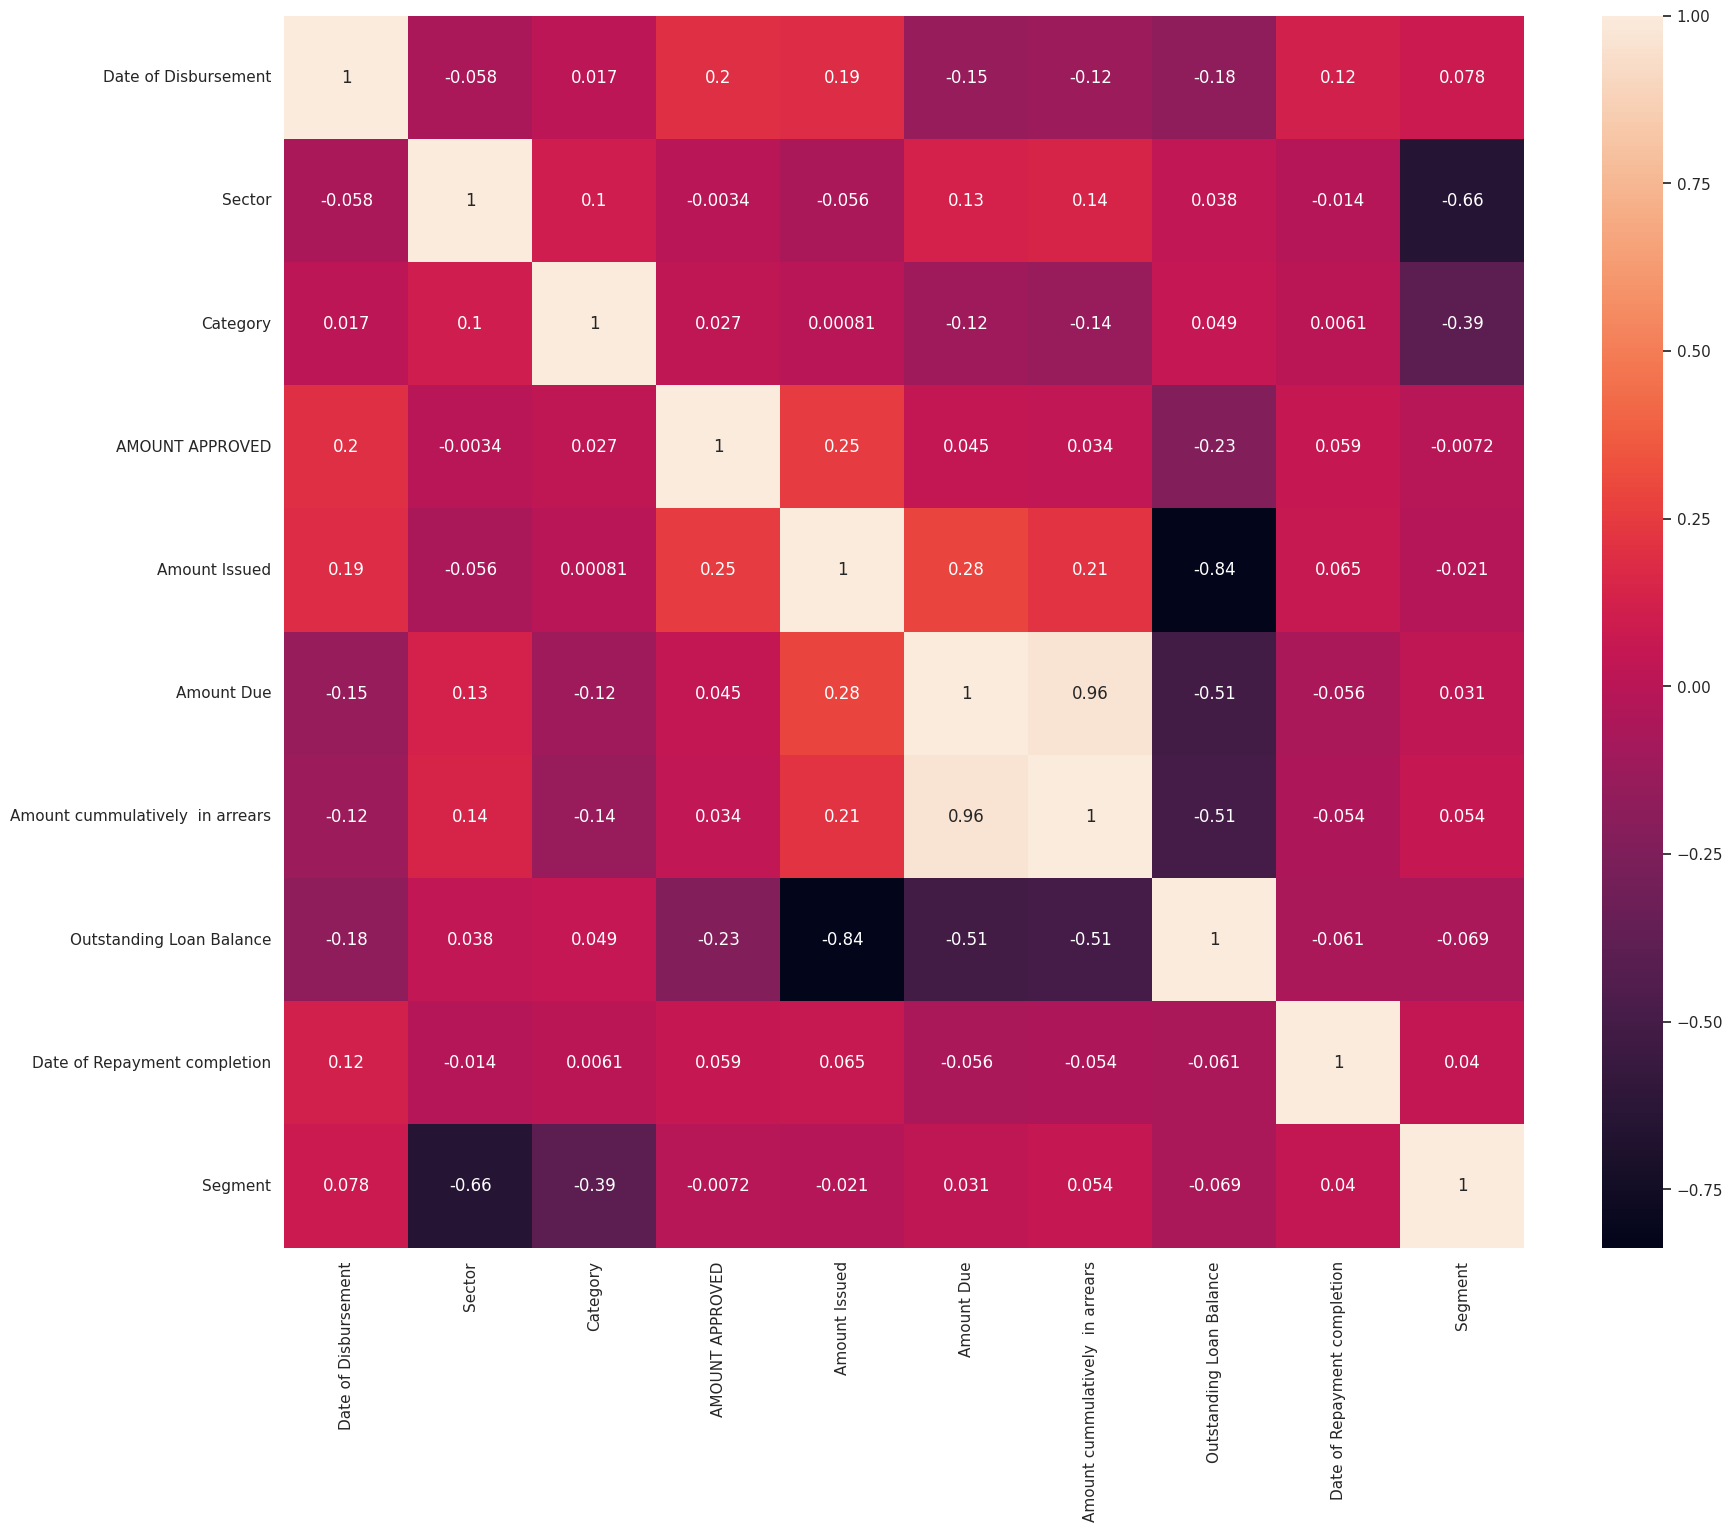

In [ ]:
#Correlation Heatmap (print the correlation score each variables)
plt.figure(figsize=(20, 16))
sns.heatmap(df2.corr(), fmt='.2g', annot=True)

In [ ]:
#Correlation with output variable
cor_matrix = df2.corr()
cor_target = cor_matrix["Segment"]
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.7]
relevant_features

,Segment
Segment,1.0


In [ ]:
#  dataframe with removed features
df2_fs = df2.drop(['Amount Due'], axis = 1)

<Axes: >

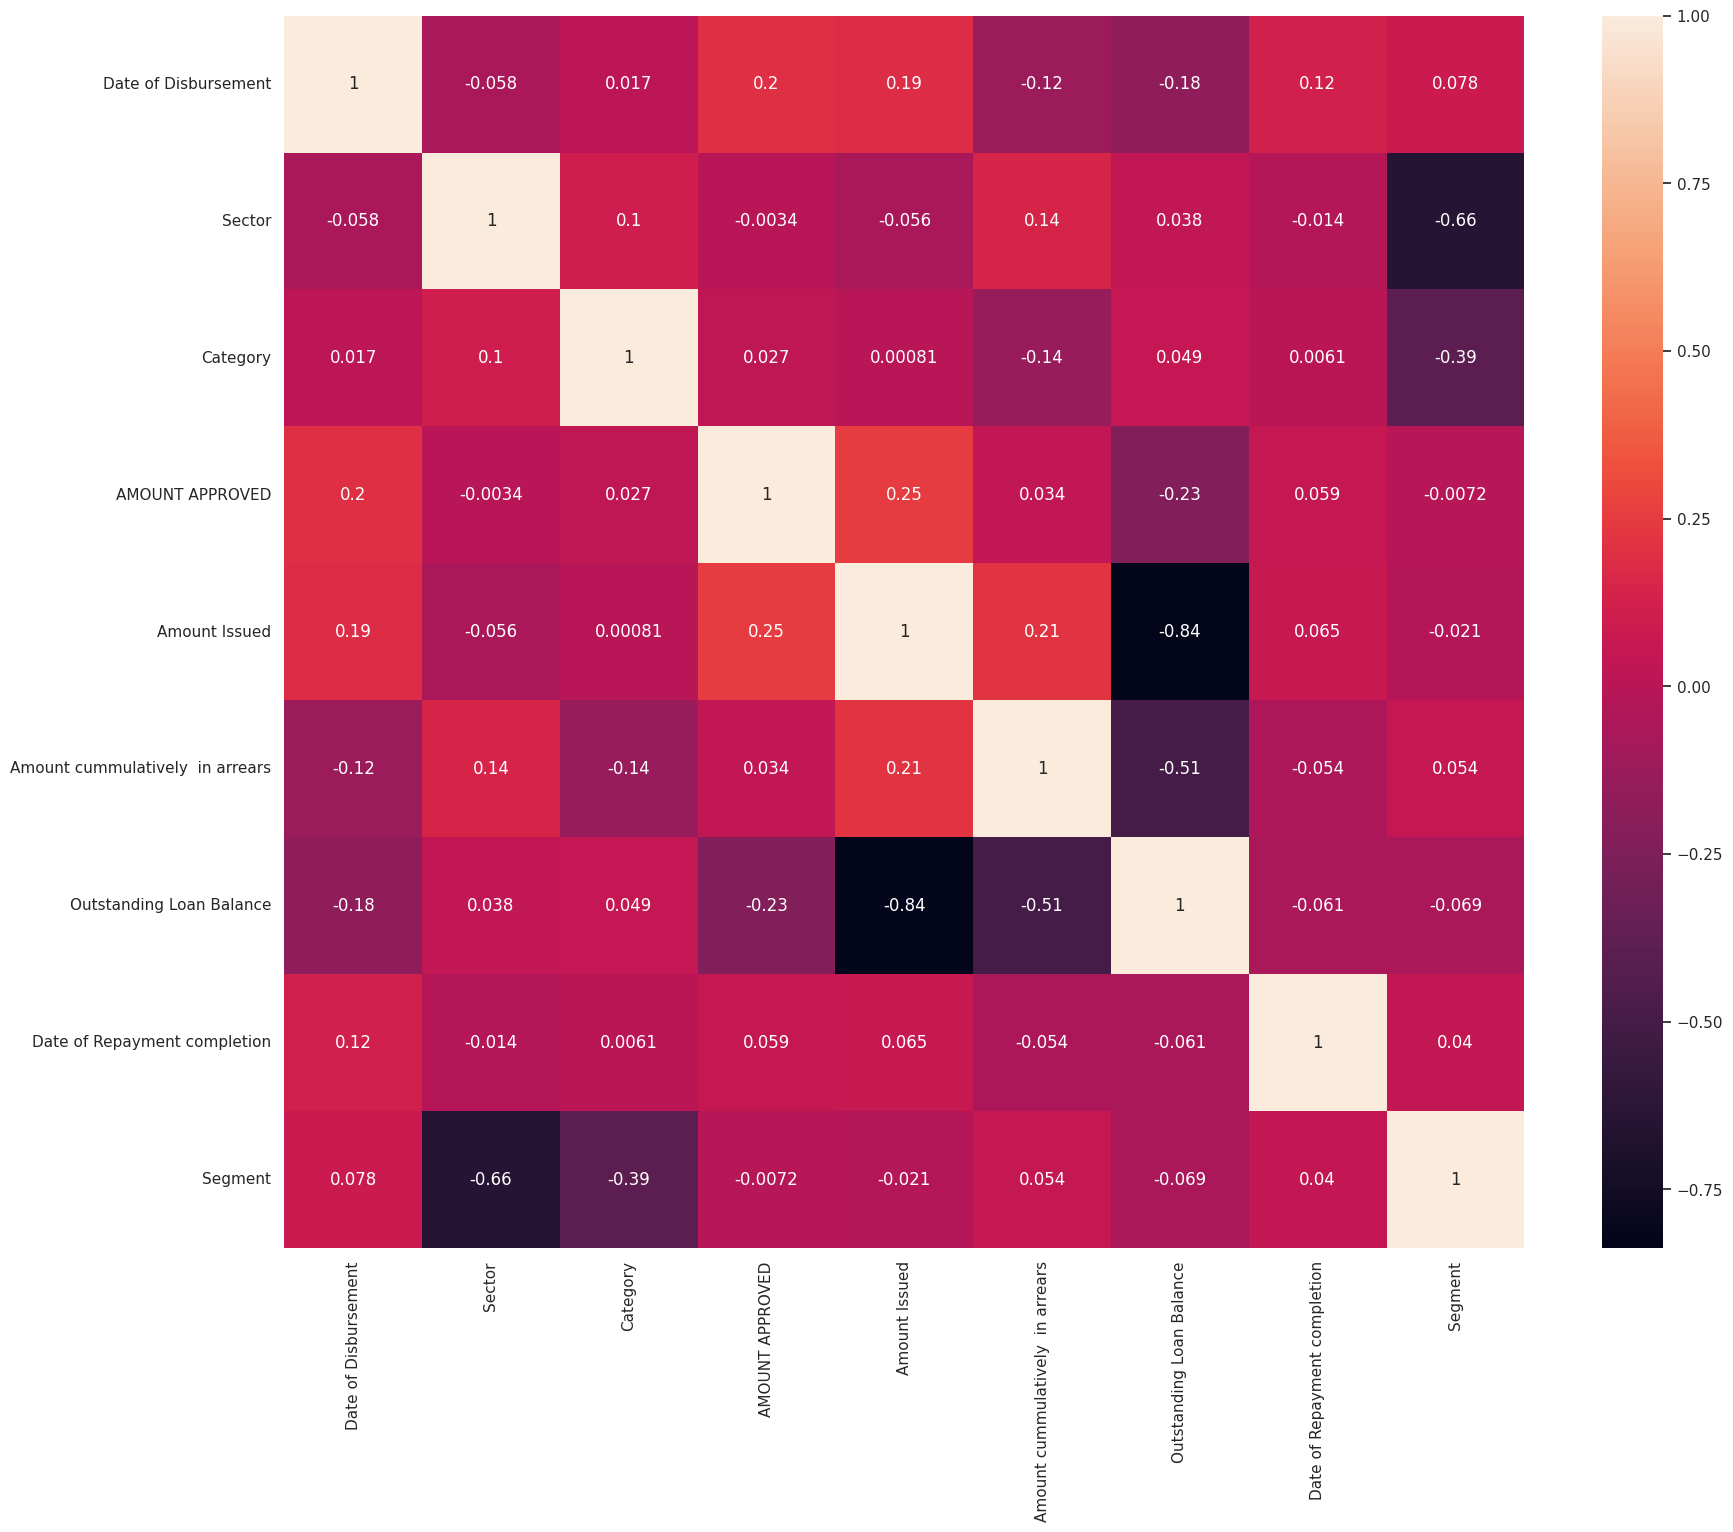

In [ ]:
#Correlation Heatmap (print the correlation score each variables)
plt.figure(figsize=(20, 16))
sns.heatmap(df2_fs.corr(), fmt='.2g', annot=True)

In [ ]:
#Check missing value
check_missing = df2_fs.isnull().sum() * 100 / df2_fs.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

,0
Outstanding Loan Balance,16.710875
Sector,1.414677
Amount cummulatively in arrears,1.414677
Amount Issued,1.414677
Category,1.326260
Date of Repayment completion,0.176835


In [ ]:

# Replace NaN values with the median of the column
df2_fs['Outstanding Loan Balance'].fillna(df2_fs['Outstanding Loan Balance'].median(), inplace=True)
df2_fs['Sector'].fillna(df2_fs['Sector'].median(), inplace=True)
df2_fs['Category'].fillna(df2_fs['Category'].median(), inplace=True)
df2_fs['Amount Issued'].fillna(df2_fs['Amount Issued'].median(), inplace=True)
df2_fs['Date of Repayment completion'].fillna(df2_fs['Date of Repayment completion'].median(), inplace=True)
df2_fs['Amount cummulatively  in arrears'].fillna(df2_fs['Amount cummulatively  in arrears'].median(), inplace=True)

<ipython-input-14-4dba6856db29>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2_fs['Outstanding Loan Balance'].fillna(df2_fs['Outstanding Loan Balance'].median(), inplace=True)
<ipython-input-14-4dba6856db29>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

In [ ]:
#Check missing value
check_missing = df2_fs.isnull().sum() * 100 / df2_fs.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

,0


In [ ]:
df2_fs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Date of Disbursement              1131 non-null   datetime64[ns]
 1   Sector                            1131 non-null   float64       
 2   Category                          1131 non-null   float64       
 3   AMOUNT APPROVED                   1131 non-null   int64         
 4   Amount Issued                     1131 non-null   float64       
 5   Amount cummulatively  in arrears  1131 non-null   float64       
 6   Outstanding Loan Balance          1131 non-null   float64       
 7   Date of Repayment completion      1131 non-null   datetime64[ns]
 8   Segment                           1131 non-null   int64         
dtypes: datetime64[ns](2), float64(5), int64(2)
memory usage: 79.7 KB


In [ ]:
# saving the dataframe
df2_fs.to_csv('preprocessed0_Uwezo.csv')

In [ ]:
#generate a new attribute from the dates
# Calculate the difference between two dates and add it as a new column.
import datetime

df2_fs['Length of Credit'] = (df2_fs['Date of Repayment completion'] - df2_fs['Date of Disbursement']).dt.days

In [ ]:
df2_fs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Date of Disbursement              1131 non-null   datetime64[ns]
 1   Sector                            1131 non-null   float64       
 2   Category                          1131 non-null   float64       
 3   AMOUNT APPROVED                   1131 non-null   int64         
 4   Amount Issued                     1131 non-null   float64       
 5   Amount cummulatively  in arrears  1131 non-null   float64       
 6   Outstanding Loan Balance          1131 non-null   float64       
 7   Date of Repayment completion      1131 non-null   datetime64[ns]
 8   Segment                           1131 non-null   int64         
 9   Length of Credit                  1131 non-null   int64         
dtypes: datetime64[ns](2), float64(5), int64(3)
memor

In [ ]:
df3 = df2_fs .drop(['Date of Disbursement','Date of Repayment completion'], axis = 1)
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Sector                            1131 non-null   float64
 1   Category                          1131 non-null   float64
 2   AMOUNT APPROVED                   1131 non-null   int64  
 3   Amount Issued                     1131 non-null   float64
 4   Amount cummulatively  in arrears  1131 non-null   float64
 5   Outstanding Loan Balance          1131 non-null   float64
 6   Segment                           1131 non-null   int64  
 7   Length of Credit                  1131 non-null   int64  
dtypes: float64(5), int64(3)
memory usage: 70.8 KB


In [ ]:
# saving the dataframe
df3.to_csv('preprocessed_Uwezo.csv')

**Train-Validation-test split**

In [ ]:

# Separate features and target
X = df3.drop("Segment", axis=1)
y = df3["Segment"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)


(791, 7)
(113, 7)
(227, 7)
(791,)
(113,)
(227,)


In [ ]:
from collections import Counter
print(Counter(y_train))
print(Counter(y_val))
print(Counter(y_test))

Counter({0: 623, 1: 168})
Counter({0: 87, 1: 26})
Counter({0: 179, 1: 48})


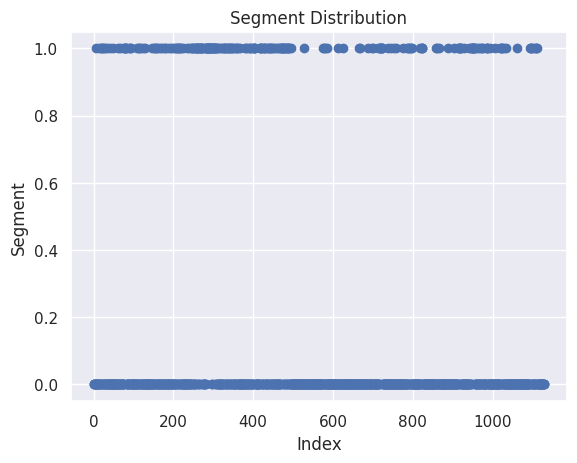

In [ ]:
import matplotlib.pyplot as plt
# Assuming 'class' is the column containing class labels
plt.scatter(df3.index, df3['Segment'])
plt.xlabel('Index')
plt.ylabel('Segment')
plt.title('Segment Distribution')
plt.show()

**Feature Scaling**

Robust scaling is a technique used to standardize features by scaling them based on the median and interquartile range (IQR). It is less affected by outliers compared to other scaling methods like standardization.

In [ ]:
# Create a RobustScaler object
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

# Fit the scaler to the data
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train

array([[-1.        , -1.        , -1.63333333, ..., -0.72806976,
         0.        , -0.08152174],
       [-2.        ,  0.        ,  0.        , ...,  0.08706365,
         0.        , -0.19021739],
       [-1.        , -1.        ,  1.66666667, ..., -0.56765498,
         1.        , -0.0923913 ],
       ...,
       [-1.        , -1.        , -1.66666667, ..., -0.78357283,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.66666667, ..., -0.78357283,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.13494865,
         0.        , -0.19021739]])

***Baseline  Models***

In [ ]:



# Initialize models
models = {
    "Logistic Regression": LogisticRegression(C=0.0001, max_iter=1000, penalty=None, solver='newton-cg'),
    "MLP Classifier": MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(50, 100, 50),
              learning_rate='adaptive'),
    "Support Vector Machine": SVC(C=100, gamma=0.01,probability=True),
    "Random Forest": RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=6,
                       n_estimators=150)
}


In [ ]:
#calculates and stores the FPR and FNR for each threshold for each baseline model:
# Train and evaluate models
# Train and evaluate models
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, fbeta_score, roc_auc_score # Import necessary metrics


thresholds = np.linspace(0, 1, 101)
results = {}
best_thresholds = {}
summary = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_val_probs = model.predict_proba(X_val)[:, 1]

    fpr_list, fnr_list = [], []
    min_diff = float('inf')
    best_t = 0.5

    for t in thresholds:
        y_pred = (y_val_probs >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        fpr_list.append(fpr)
        fnr_list.append(fnr)
        if abs(fpr - fnr) < min_diff:
            min_diff = abs(fpr - fnr)
            best_t = t

    results[name] = (fpr_list, fnr_list)
    best_thresholds[name] = best_t

    # Evaluate on test set
    y_test_probs = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_probs >= best_t).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    acc = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    f2 = fbeta_score(y_test, y_test_pred, beta=2)
    auc = roc_auc_score(y_test, y_test_probs)

    summary[name] = {
        "Threshold": round(best_t, 2),
        "FPR": round(fpr, 3),
        "FNR": round(fnr, 3),
        "Accuracy": round(acc, 3),
        "F1-Score": round(f1, 3),
        "F2-Score": round(f2, 3),
        "ROC-AUC": round(auc, 3)
    }

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: U

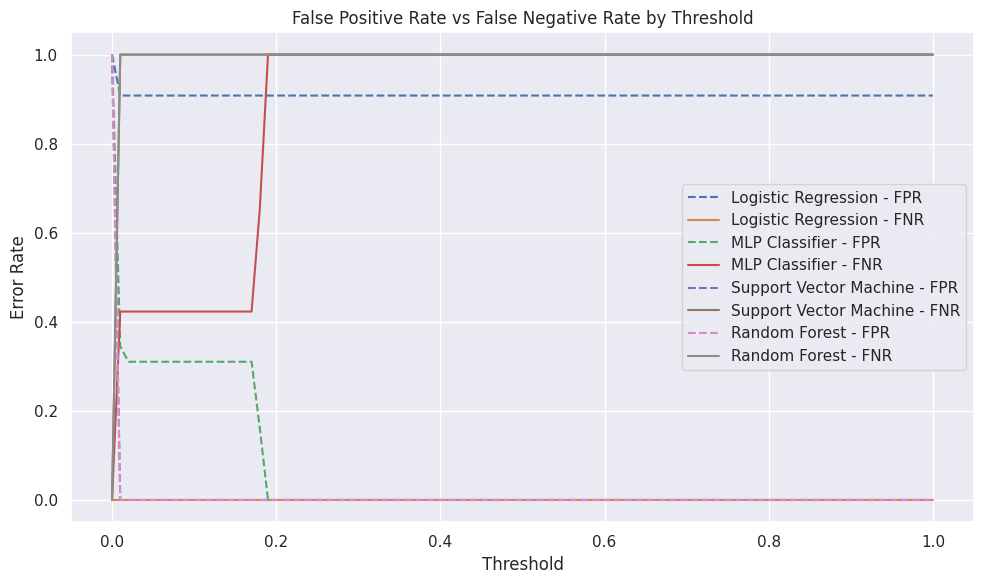

In [ ]:
#this code block plots these rates against the thresholds, visually demonstrating the trade-off:
plt.figure(figsize=(10, 6))
for name, (fpr_list, fnr_list) in results.items():
    plt.plot(thresholds, fpr_list, '--', label=f'{name} - FPR')
    plt.plot(thresholds, fnr_list, label=f'{name} - FNR')

plt.title('False Positive Rate vs False Negative Rate by Threshold')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
pd.DataFrame(summary).T


,Threshold,FPR,FNR,Accuracy,F1-Score,F2-Score,ROC-AUC
Logistic Regression,0.01,0.570,0.0,0.551,0.485,0.702,0.991
MLP Classifier,0.01,0.073,0.0,0.943,0.881,0.949,0.997
Support Vector Machine,0.00,1.000,0.0,0.211,0.349,0.573,0.996
Random Forest,0.00,1.000,0.0,0.211,0.349,0.573,0.991


from matplotlib import pyplot as plt
_df_0['Threshold'].plot(kind='hist', bins=20, title='Threshold')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['FPR'].plot(kind='hist', bins=20, title='FPR')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['F1-Score'].plot(kind='hist', bins=20, title='F1-Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Threshold', y='FPR', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='FPR', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Accuracy', y='F1-Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='F1-Score', y='F2-Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['FNR']
  ys = series['Threshold']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('FNR', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('FNR')
_ = plt.ylabel('Threshold')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['FNR']
  ys = series['FPR']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('FNR', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('FNR')
_ = plt.ylabel('FPR')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['FNR']
  ys = series['Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('FNR', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('FNR')
_ = plt.ylabel('Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['FNR']
  ys = series['F1-Score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('FNR', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('FNR')
_ = plt.ylabel('F1-Score')

from matplotlib import pyplot as plt
_df_12['Threshold'].plot(kind='line', figsize=(8, 4), title='Threshold')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['FPR'].plot(kind='line', figsize=(8, 4), title='FPR')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['F1-Score'].plot(kind='line', figsize=(8, 4), title='F1-Score')
plt.gca().spines[['top', 'right']].set_visible(False)

**Experiment Two**

In [ ]:
# Apply SMOTE (oversampling minority class)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apply NearMiss (undersampling majority class)
nearmiss = NearMiss()
X_train_nm, y_train_nm = nearmiss.fit_resample(X_train, y_train)

print("Original class distribution:", y_train.value_counts().to_dict())
print("SMOTE class distribution:   ", pd.Series(y_train_smote).value_counts().to_dict())
print("NearMiss class distribution:", pd.Series(y_train_nm).value_counts().to_dict())


Original class distribution: {0: 623, 1: 168}
SMOTE class distribution:    {1: 623, 0: 623}
NearMiss class distribution: {0: 168, 1: 168}


In [ ]:
def train_and_evaluate_balanced(X_train_resampled, y_train_resampled, label):
    temp_summary = {}

    for name, model in models.items():
        model.fit(X_train_resampled, y_train_resampled)
        y_val_probs = model.predict_proba(X_val)[:, 1]
        y_val_pred = (y_val_probs >= 0.5).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

        temp_summary[f"{name} ({label})"] = {
            "FPR": round(fpr, 3),
            "FNR": round(fnr, 3),
            "Accuracy": round(accuracy_score(y_val, y_val_pred), 3),
            "F1-Score": round(f1_score(y_val, y_val_pred), 3),
            "F2-Score": round(fbeta_score(y_val, y_val_pred, beta=2), 3),
            "ROC-AUC": round(roc_auc_score(y_val, y_val_probs), 3)
        }

    return temp_summary


In [ ]:
summary_smote = train_and_evaluate_balanced(X_train_smote, y_train_smote, "SMOTE")
summary_nm = train_and_evaluate_balanced(X_train_nm, y_train_nm, "NearMiss")
# Display the summary for models trained on SMOTE data
print("Summary for Models Trained with SMOTE:")
display(pd.DataFrame(summary_smote).T)

# Display the summary for models trained on NearMiss data
print("\nSummary for Models Trained with NearMiss:")
display(pd.DataFrame(summary_nm).T)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: U

Summary for Models Trained with SMOTE:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,FPR,FNR,Accuracy,F1-Score,F2-Score,ROC-AUC
Logistic Regression (SMOTE),0.908,0.000,0.301,0.397,0.622,0.546
MLP Classifier (SMOTE),0.586,0.192,0.504,0.429,0.597,0.607
Support Vector Machine (SMOTE),0.000,1.000,0.770,0.000,0.000,0.500
Random Forest (SMOTE),0.000,1.000,0.770,0.000,0.000,0.500



Summary for Models Trained with NearMiss:


,FPR,FNR,Accuracy,F1-Score,F2-Score,ROC-AUC
Logistic Regression (NearMiss),0.908,0.0,0.301,0.397,0.622,0.546
MLP Classifier (NearMiss),0.920,0.0,0.292,0.394,0.619,0.492
Support Vector Machine (NearMiss),0.000,1.0,0.770,0.000,0.000,0.500
Random Forest (NearMiss),0.000,1.0,0.770,0.000,0.000,0.500


In [ ]:
summary_balanced = {**summary_smote, **summary_nm}
pd.DataFrame(summary_balanced).T


,FPR,FNR,Accuracy,F1-Score,F2-Score,ROC-AUC
Logistic Regression (SMOTE),0.908,0.000,0.301,0.397,0.622,0.546
MLP Classifier (SMOTE),0.586,0.192,0.504,0.429,0.597,0.607
Support Vector Machine (SMOTE),0.000,1.000,0.770,0.000,0.000,0.500
Random Forest (SMOTE),0.000,1.000,0.770,0.000,0.000,0.500
Logistic Regression (NearMiss),0.908,0.000,0.301,0.397,0.622,0.546
MLP Classifier (NearMiss),0.920,0.000,0.292,0.394,0.619,0.492
Support Vector Machine (NearMiss),0.000,1.000,0.770,0.000,0.000,0.500
Random Forest (NearMiss),0.000,1.000,0.770,0.000,0.000,0.500


**Experiment Three**

In [ ]:
# Create a RobustScaler object
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

# Fit the scaler to the data
scaler.fit(X_train)

# Transform the data and convert back to pandas DataFrames/Series
X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_valid = pd.DataFrame(scaler.transform(X_val), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# y variables are already Series, no need to convert back
X_train

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


,Sector,Category,AMOUNT APPROVED,Amount Issued,Amount cummulatively in arrears,Outstanding Loan Balance,Length of Credit
0,-1.0,-1.0,-1.633333,0.0,-0.728070,0.0,-0.081522
1,-2.0,0.0,0.000000,0.0,0.087064,0.0,-0.190217
2,-1.0,-1.0,1.666667,-1.0,-0.567655,1.0,-0.092391
3,-1.0,-1.0,-1.666667,0.0,-0.713922,1.0,0.000000
4,-2.0,-1.0,0.000000,0.0,-0.783573,0.0,-0.190217
...,...,...,...,...,...,...,...
786,-1.0,0.0,-0.833333,0.0,1.175359,0.0,0.239130
787,0.0,0.0,0.000000,0.0,1.703836,0.0,-0.086957
788,-1.0,-1.0,-1.666667,-1.0,-0.783573,0.0,0.000000
789,0.0,0.0,-0.666667,0.0,-0.783573,0.0,0.000000


In [ ]:
# baseline models selected
best_models = {
    "Logistic Regression": LogisticRegression(C=0.0001, max_iter=1000, penalty=None, solver='newton-cg'),
    "MLP Classifier": MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(50, 100, 50),
              learning_rate='adaptive'),
}

# Merge train + validation
# Since X_train and X_val are now DataFrames after scaling and conversion, concat will work.
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])


In [ ]:
# Train the models
trained_best_models = { "Logistic Regression": LogisticRegression(C=0.0001, max_iter=1000, penalty=None, solver='newton-cg'),
    "MLP Classifier": MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(50, 100, 50),
              learning_rate='adaptive'),}
for name, model in best_models.items():
    model.fit(X_train_full, y_train_full)
    trained_best_models[name] = model


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


In [ ]:
thresholds = np.linspace(0, 1, 101)
threshold_results = {}

for name, model in trained_best_models.items():
    y_test_probs = model.predict_proba(X_test)[:, 1]

    best_threshold = 0.5
    best_diff = float('inf')
    best_metrics = {}

    for t in thresholds:
        y_pred = (y_test_probs >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        diff = abs(fpr - fnr)

        if diff < best_diff:
            best_diff = diff
            best_threshold = t
            best_metrics = {
                "Threshold": round(t, 2),
                "FPR": round(fpr, 3),
                "FNR": round(fnr, 3),
                "Accuracy": round(accuracy_score(y_test, y_pred), 3),
                "F1-Score": round(f1_score(y_test, y_pred), 3),
                "F2-Score": round(fbeta_score(y_test, y_pred, beta=2), 3),
                "ROC-AUC": round(roc_auc_score(y_test, y_test_probs), 3)
            }

    threshold_results[name] = best_metrics


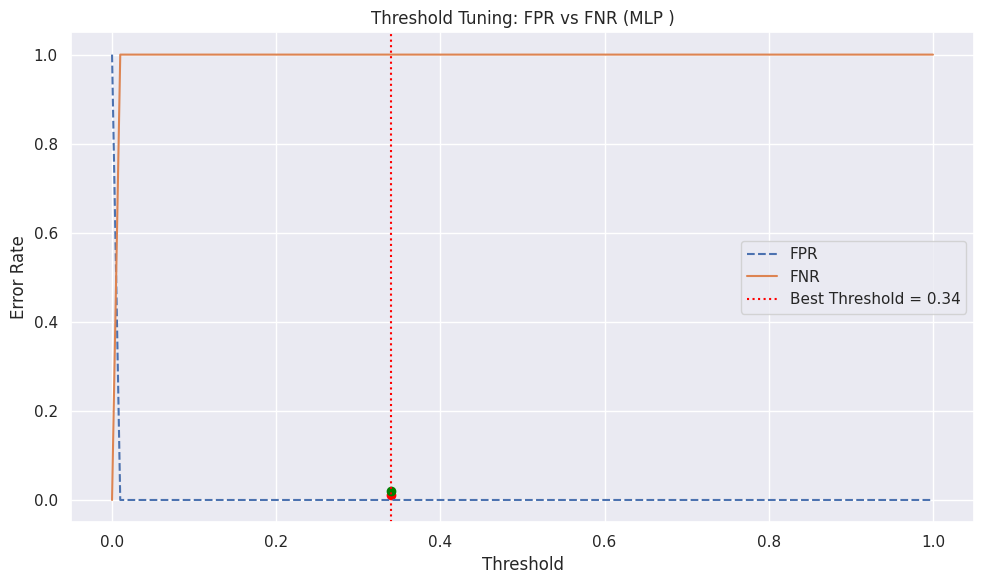

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fpr_list, label="FPR", linestyle='--')
plt.plot(thresholds, fnr_list, label="FNR")

# Mark the optimal threshold
plt.axvline(best_threshold, color='red', linestyle=':', label=f'Best Threshold = {best_threshold:.2f}')
plt.scatter([best_threshold], [best_metrics['FPR']], color='red')
plt.scatter([best_threshold], [best_metrics['FNR']], color='green')

plt.title("Threshold Tuning: FPR vs FNR (MLP )")
plt.xlabel("Threshold")
plt.ylabel("Error Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("📊 Best Threshold Metrics for MLP :")
for metric, value in best_metrics.items():
    print(f"{metric}: {value}")


📊 Best Threshold Metrics for MLP :
Threshold: 0.34
FPR: 0.011
FNR: 0.021
Accuracy: 0.987
F1-Score: 0.969
F2-Score: 0.975
ROC-AUC: 0.997
